/Users/Garrett/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(50000, 28, 28) (50000,)


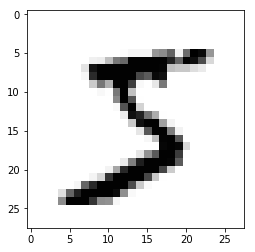

In [1]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [2]:
import tensorflow as tf
import numpy as np

In [3]:
img_h = img_w = 28             # MNIST images are 28x28 
img_size = img_h * img_w       # 28x28=784, the total number of pixels
n_classes = 10                 # Number of classes, one class per digit

In [4]:
X_train = X_train.reshape([-1, img_size])
X_val = X_val.reshape([-1, img_size])
X_test = X_test.reshape([-1, img_size])

def shuffle():
    permutation = np.random.permutation(y_train.shape[0])
    shuffled_X = X_train[permutation, :]
    shuffled_y = y_train[permutation]
    return shuffled_X, shuffled_y

X_train, y_train = shuffle()

print(y_train[0:5])
def get_one_hot(y):
    y_one_hot = np.eye(n_classes)[y]
    
    return y_one_hot

y_train = get_one_hot(y_train)
y_val = get_one_hot(y_val)
y_test = get_one_hot(y_test)

print(X_train.shape)
print(y_train.shape)
print(y_train[0:5])

[1 3 1 2 1]
(50000, 784)
(50000, 10)
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [5]:
# Hyper-parameters
epochs = 100             # Total number of training epochs
learning_rate = 0.0003       # The optimization initial learning rate
n_neurons_1 = 512          # number of neurons in hidden layer 1
n_neurons_2 = 256          # number of neurons in hidden layer 2
batch_size = 256         # batch size 
dropout_keep_prob = 0.65          # dropout keep prob

In [6]:
X = tf.placeholder(tf.float32, shape=(None, img_size), name='X')
y = tf.placeholder(tf.float32, shape=(None, n_classes), name='y')
keep_prob = tf.placeholder(tf.float32)

In [7]:
# init_w = tf.truncated_normal_initializer(stddev=0.01)
init_w = tf.contrib.layers.xavier_initializer()
W1 = tf.get_variable('W1', dtype=tf.float32, shape=(img_size, n_neurons_1), initializer=init_w)
W2 = tf.get_variable('W2', dtype=tf.float32, shape=(n_neurons_1, n_neurons_2), initializer=init_w)
W3 = tf.get_variable('W3', dtype=tf.float32, shape=(n_neurons_2, n_classes), initializer=init_w)

b1 = tf.get_variable('b1', dtype=tf.float32, shape=(n_neurons_1), initializer=tf.zeros_initializer())
b2 = tf.get_variable('b2', dtype=tf.float32, shape=(n_neurons_2), initializer=tf.zeros_initializer())
b3 = tf.get_variable('b3', dtype=tf.float32, shape=(n_classes), initializer=tf.zeros_initializer())

Z1 = tf.matmul(X, W1) + b1
A1 = tf.nn.tanh(Z1)
A1 = tf.nn.dropout(A1, keep_prob)
Z2 = tf.matmul(A1, W2) + b2
A2 = tf.nn.tanh(Z2)
A2 = tf.nn.dropout(A2, keep_prob)
Z3 = tf.matmul(A2, W3) + b3
# A3 = tf.nn.softmax(Z3)
A3 = Z3
output = A3

In [8]:
# Define the loss function, optimizer, and accuracy
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output), name='loss')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam').minimize(loss)
# _, accuracy = tf.metrics.accuracy(labels=tf.argmax(y, 1), predictions=tf.argmax(A2, 1), name='accuracy')

correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1), name='correct_pred')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [9]:
def get_batch(start, end):
    X_batch = X_train[start: end]
    y_batch = y_train[start: end]
    
    return X_batch, y_batch

n_instance = X_train.shape[0]
batches = np.ceil(n_instance / batch_size).astype(int)

In [10]:
sess = tf.Session()

init = tf.group(tf.local_variables_initializer(), tf.global_variables_initializer())
sess.run(init)
    
# loss and accuracy before start
feed_dict_train = {X: X_train, y: y_train, keep_prob: 1}
loss_train, accuracy_train = sess.run([loss, accuracy], feed_dict=feed_dict_train)    
print("before start,    train loss {0:.2f},    train accuracy {1:.01%}".format(loss_train, accuracy_train))

before start,    train loss 2.44,    train accuracy 5.5%


In [11]:
# training phase
losses_train = []
losses_val = []
for epoch in range(epochs):

    for batch in range(batches):
        begin = batch * batch_size
        X_batch, y_batch = get_batch(begin, begin + batch_size)
        feed_dict_batch = {X: X_batch, y: y_batch, keep_prob: dropout_keep_prob}
        sess.run(optimizer, feed_dict=feed_dict_batch)

    feed_dict_train = {X: X_train, y: y_train, keep_prob: 1}
    loss_train, accuracy_train = sess.run([loss, accuracy], feed_dict=feed_dict_train)
    print("epoch {0:3d},    train loss {1:.4f},    train accuracy {2:.02%}".format(epoch, loss_train, accuracy_train), end="")
    losses_train.append(loss_train)

    feed_dict_val = {X: X_val, y: y_val, keep_prob: 1}
    loss_val, accuracy_val = sess.run([loss, accuracy], feed_dict=feed_dict_val)
    print("     val loss {1:.4f},    val accuracy {2:.02%}".format(epoch, loss_val, accuracy_val))
    losses_val.append(loss_val)

epoch   0,    train loss 0.3025,    train accuracy 91.23%     val loss 0.2824,    val accuracy 91.89%
epoch   1,    train loss 0.2563,    train accuracy 92.52%     val loss 0.2469,    val accuracy 92.84%
epoch   2,    train loss 0.2283,    train accuracy 93.33%     val loss 0.2230,    val accuracy 93.69%
epoch   3,    train loss 0.2068,    train accuracy 93.87%     val loss 0.2070,    val accuracy 94.18%
epoch   4,    train loss 0.1871,    train accuracy 94.44%     val loss 0.1906,    val accuracy 94.61%
epoch   5,    train loss 0.1674,    train accuracy 95.03%     val loss 0.1743,    val accuracy 95.19%
epoch   6,    train loss 0.1554,    train accuracy 95.37%     val loss 0.1652,    val accuracy 95.23%
epoch   7,    train loss 0.1405,    train accuracy 95.74%     val loss 0.1528,    val accuracy 95.60%
epoch   8,    train loss 0.1297,    train accuracy 96.15%     val loss 0.1448,    val accuracy 95.81%
epoch   9,    train loss 0.1208,    train accuracy 96.36%     val loss 0.1383,    

epoch  81,    train loss 0.0037,    train accuracy 99.94%     val loss 0.0743,    val accuracy 98.02%
epoch  82,    train loss 0.0037,    train accuracy 99.94%     val loss 0.0720,    val accuracy 98.11%
epoch  83,    train loss 0.0034,    train accuracy 99.94%     val loss 0.0720,    val accuracy 98.10%
epoch  84,    train loss 0.0034,    train accuracy 99.95%     val loss 0.0743,    val accuracy 98.07%
epoch  85,    train loss 0.0032,    train accuracy 99.95%     val loss 0.0730,    val accuracy 97.99%
epoch  86,    train loss 0.0030,    train accuracy 99.95%     val loss 0.0727,    val accuracy 98.13%
epoch  87,    train loss 0.0027,    train accuracy 99.96%     val loss 0.0715,    val accuracy 98.08%
epoch  88,    train loss 0.0026,    train accuracy 99.97%     val loss 0.0750,    val accuracy 98.02%
epoch  89,    train loss 0.0028,    train accuracy 99.95%     val loss 0.0747,    val accuracy 98.08%
epoch  90,    train loss 0.0027,    train accuracy 99.96%     val loss 0.0739,    

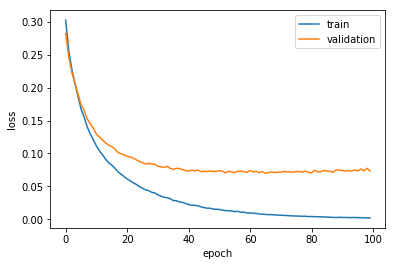

In [12]:
# plot loss
plt.plot(losses_train, label='train')
plt.plot(losses_val, label='validation')

plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend()
plt.show()

In [13]:
# testing phase
feed_dict_test = {X: X_test, y: y_test, keep_prob: 1}
loss_test, accuracy_test = sess.run([loss, accuracy], feed_dict=feed_dict_test)
print("final,    test loss {1:.4f},    test accuracy {2:.02%}".format(epoch, loss_test, accuracy_test))

sess.close()

final,    test loss 0.0677,    test accuracy 98.19%
